In [1]:
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-05-01 23:45:15.992687: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 23:45:16.146650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 23:45:16.697219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 23:45:18.722699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
results_file = "write/PBMC.h5ad"  

In [4]:
directory_path = '/mnt/c/Users/TAMALIKA/Onedrive/Desktop/gr/'
file_path = f'{directory_path}/raw_feature_bc_matrix'  # Full path to the matrix.mtx file

adata = sc.read_10x_mtx(
    file_path,                                   # the directory with the `.mtx` file
    var_names='gene_symbols',                    # use gene symbols for the variable names (variables-axis index)
    cache=True)


... reading from cache file cache/mnt-c-Users-TAMALIKA-Onedrive-Desktop-gr-raw_feature_bc_matrix-matrix.h5ad


/home/tamalika/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
adata

AnnData object with n_obs × n_vars = 730193 × 38606
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


/home/tamalika/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


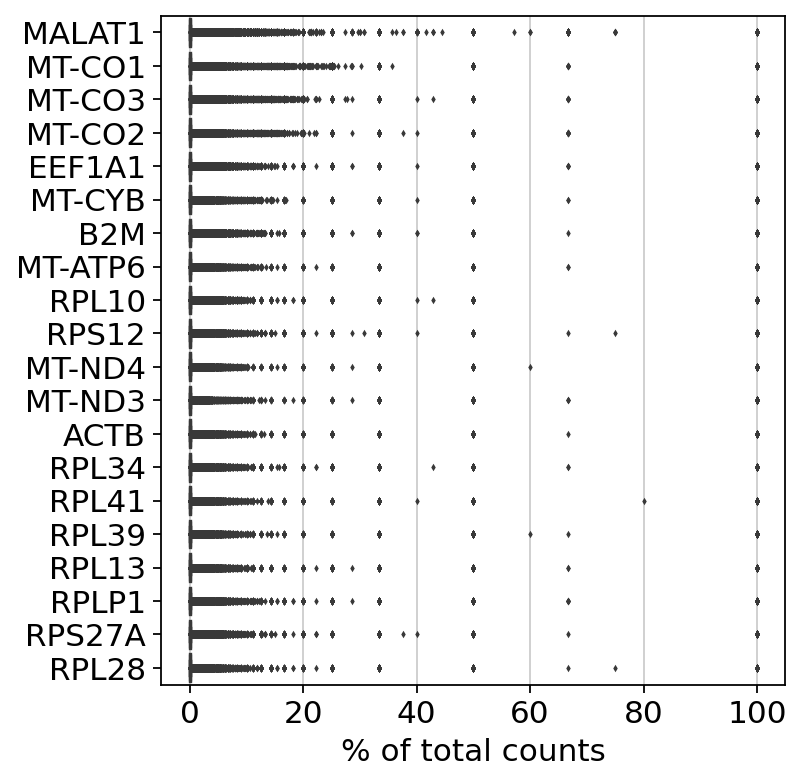

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [7]:
#basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 724961 cells that have less than 200 genes expressed
filtered out 13320 genes that are detected in less than 3 cells


In [8]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

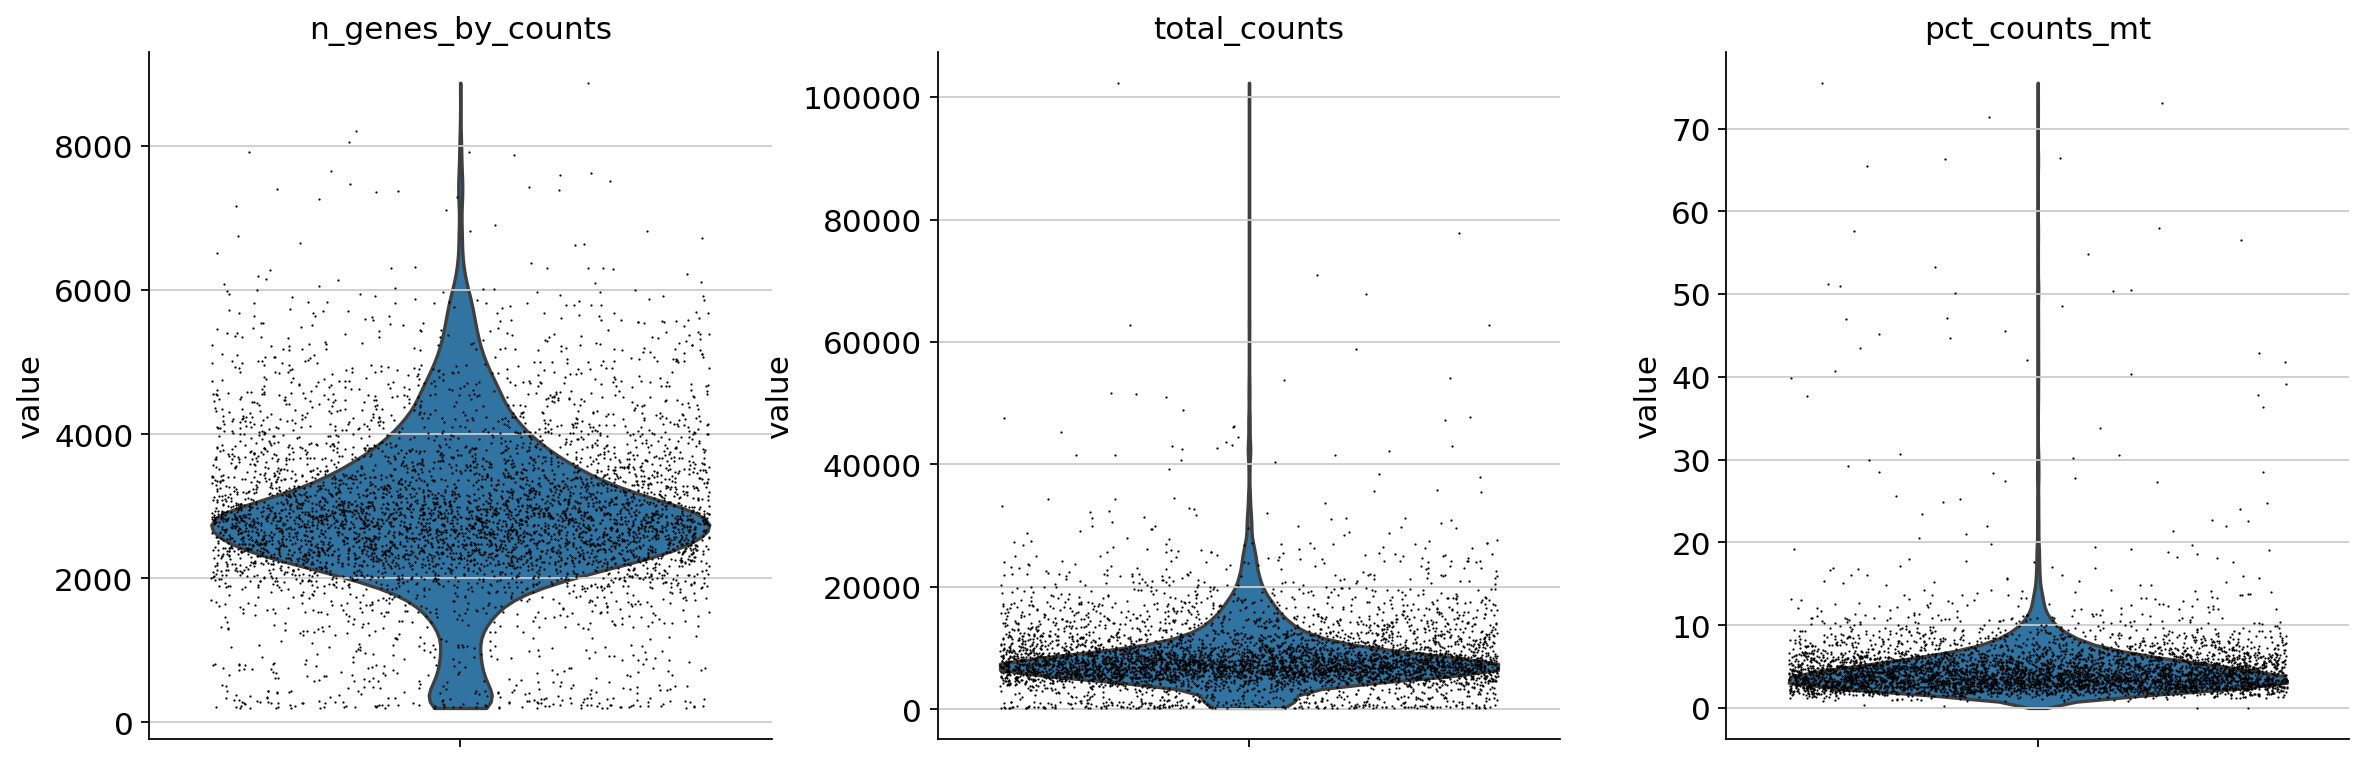

In [9]:
#A violin plot of some of the computed quality measures:
#the number of genes expressed in the count matrix
#the total counts per cell
#the percentage of counts in mitochondrial genes

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

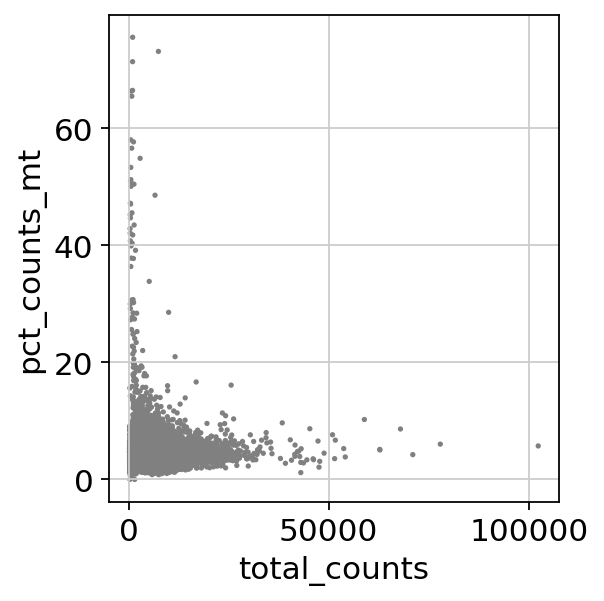

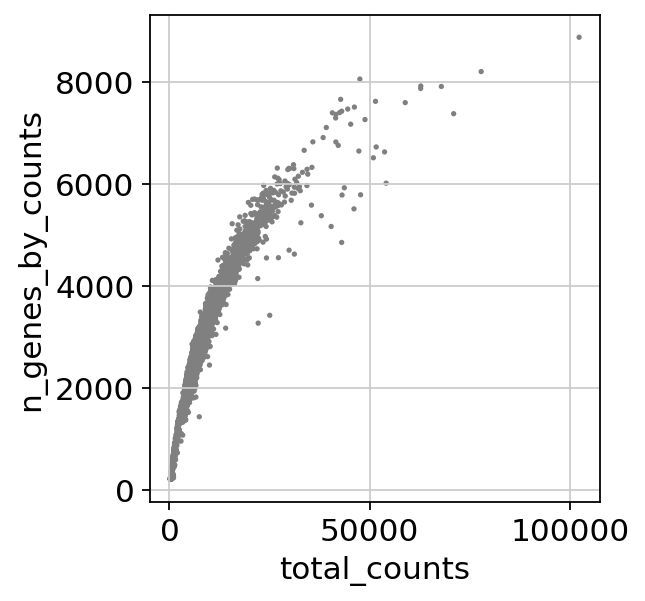

In [10]:
#Remove cells that have too many mitochondrial genes expressed or too many total counts
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [11]:
# do the filtering by slicing the AnnData object.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [12]:
#Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [13]:
#Logarithmize the data:
sc.pp.log1p(adata)

In [14]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


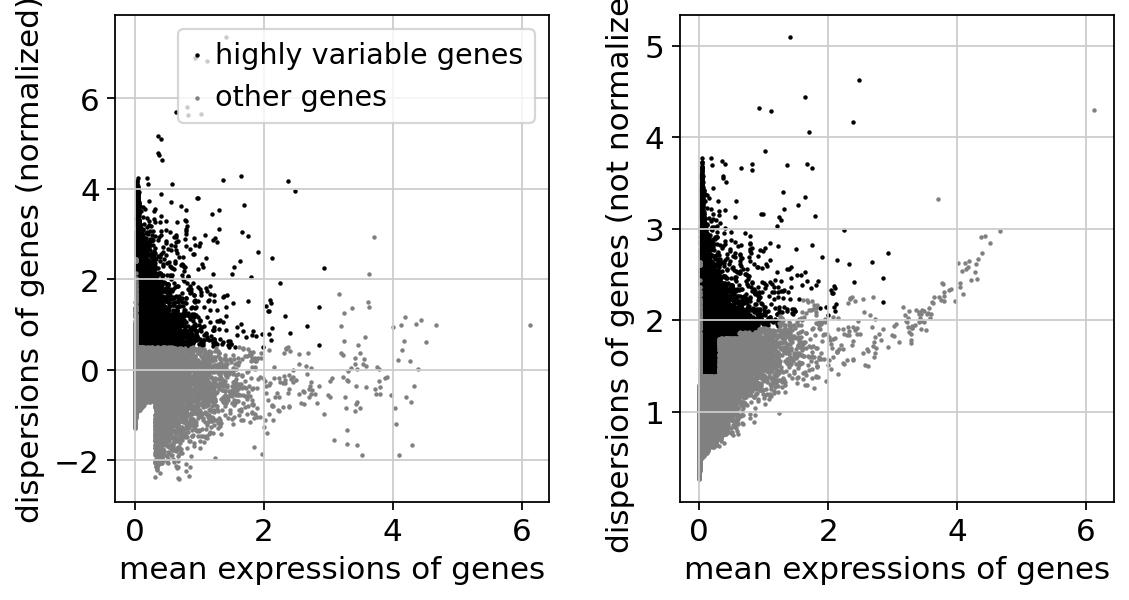

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
#Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata

In [17]:
#the filtering
adata = adata[:, adata.var.highly_variable]

In [18]:
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [19]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [20]:
#Principal component analysis
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


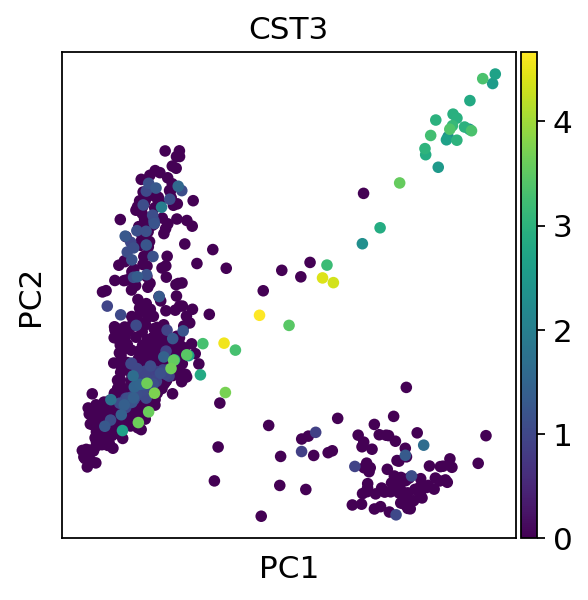

In [21]:
#make a scatter plot in the PCA coordinates, but we will not use that later on.
sc.pl.pca(adata, color="CST3")

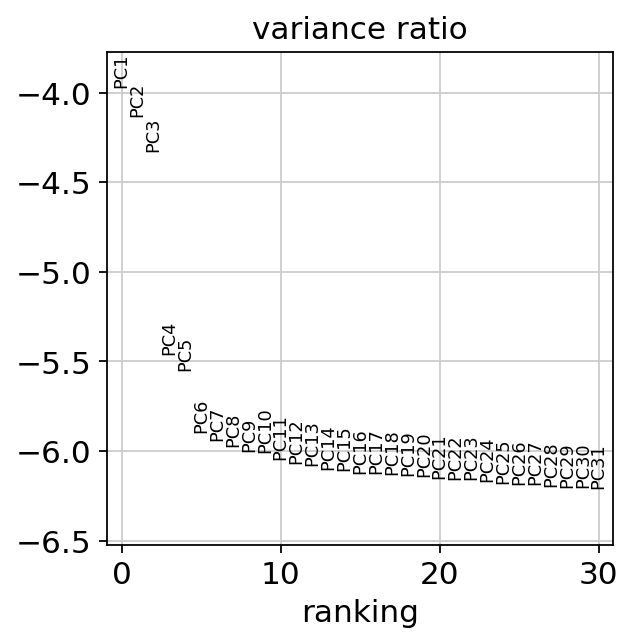

In [22]:
#inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells.
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
adata.write(results_file)

In [24]:
adata

AnnData object with n_obs × n_vars = 1108 × 5089
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
# compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [26]:
# embedding the graph in two dimensions using UMAP. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.
sc.tl.leiden(adata) #(changed the code a bit from source)
# Run PAGA with the computed community labels
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


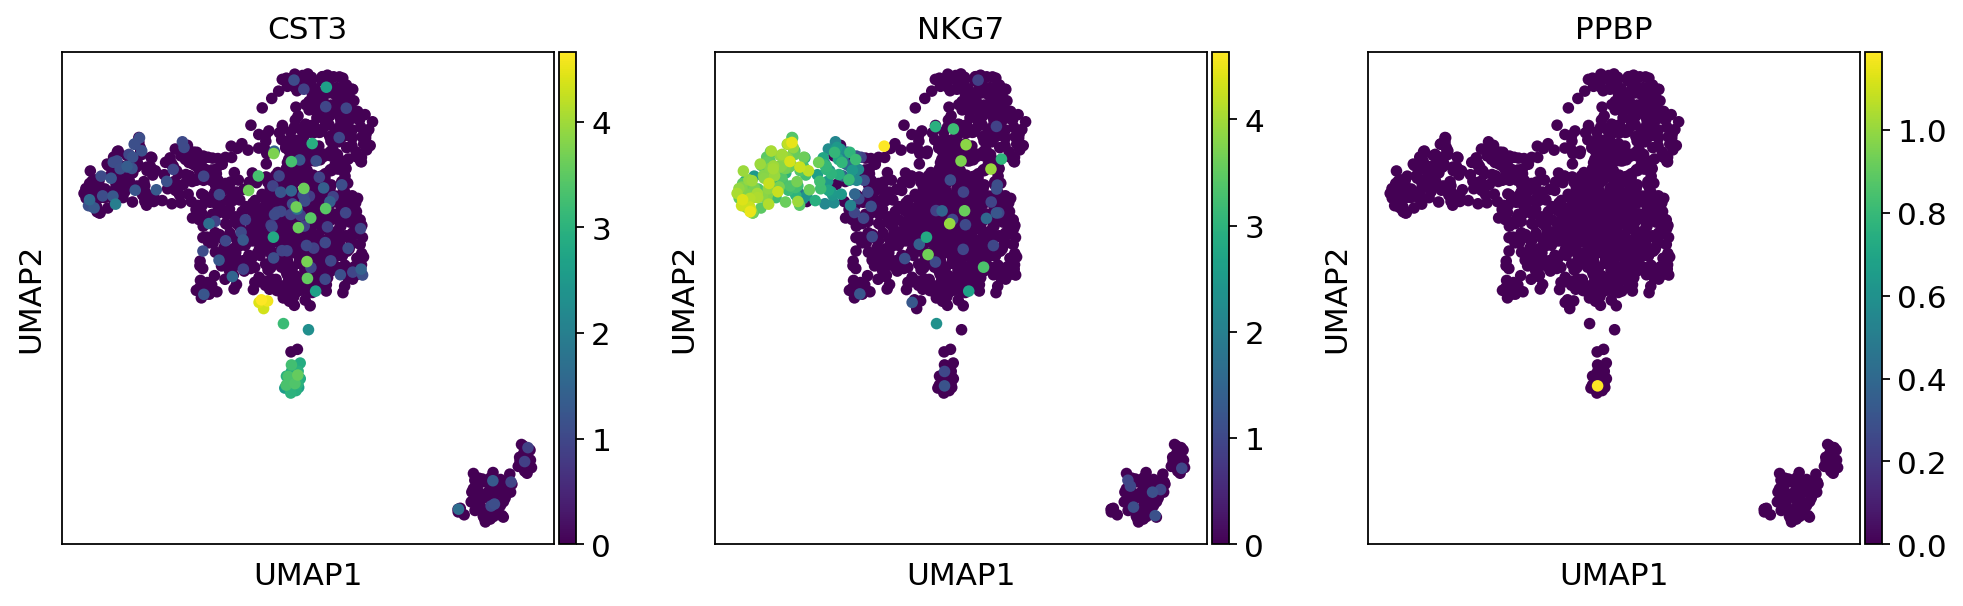

In [27]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"]) #showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. 

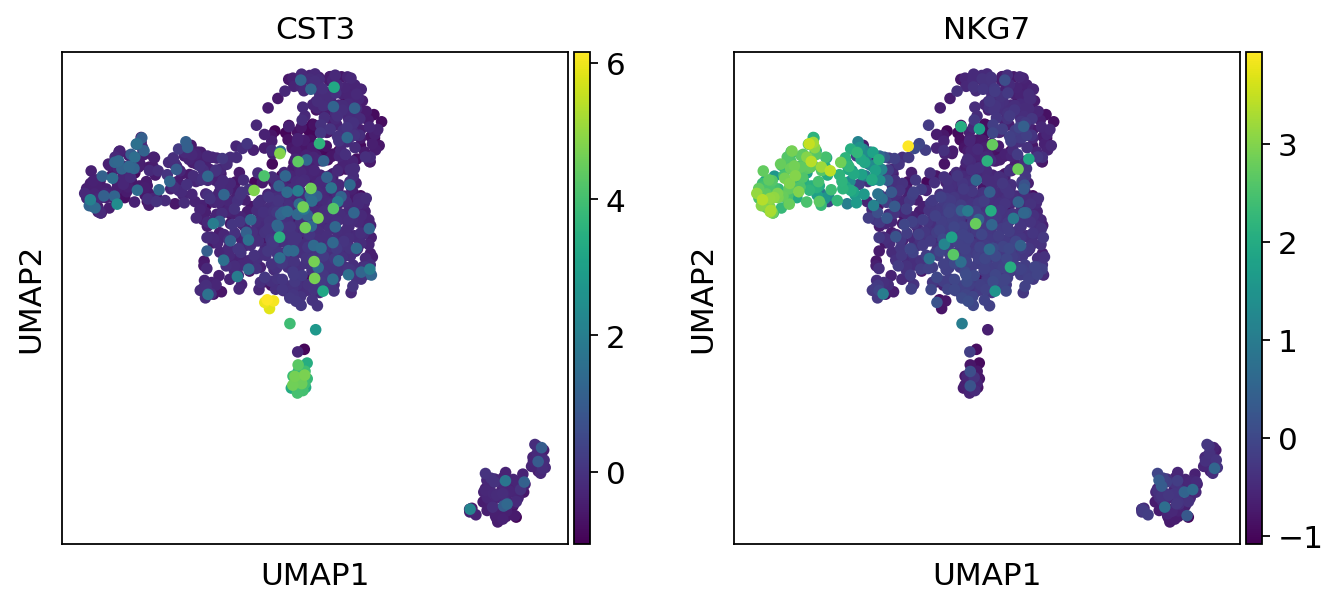

In [28]:
#plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.
sc.pl.umap(adata, color=["CST3", "NKG7"], use_raw=False)

In [29]:
#Clustering the neighborhood graph ( remived flavor = "igraph")
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/tamalika/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


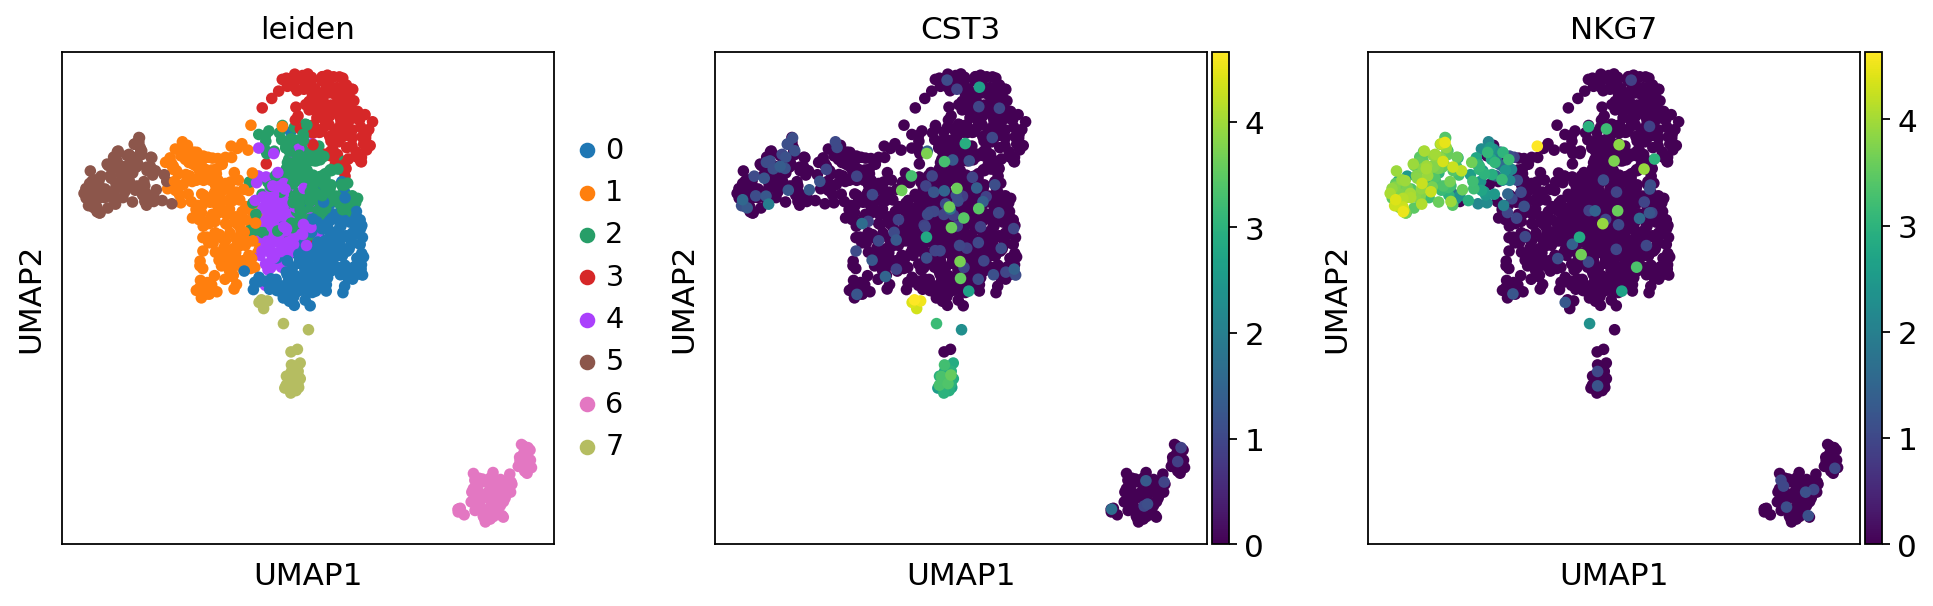

In [30]:
#plot the clusters
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [31]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


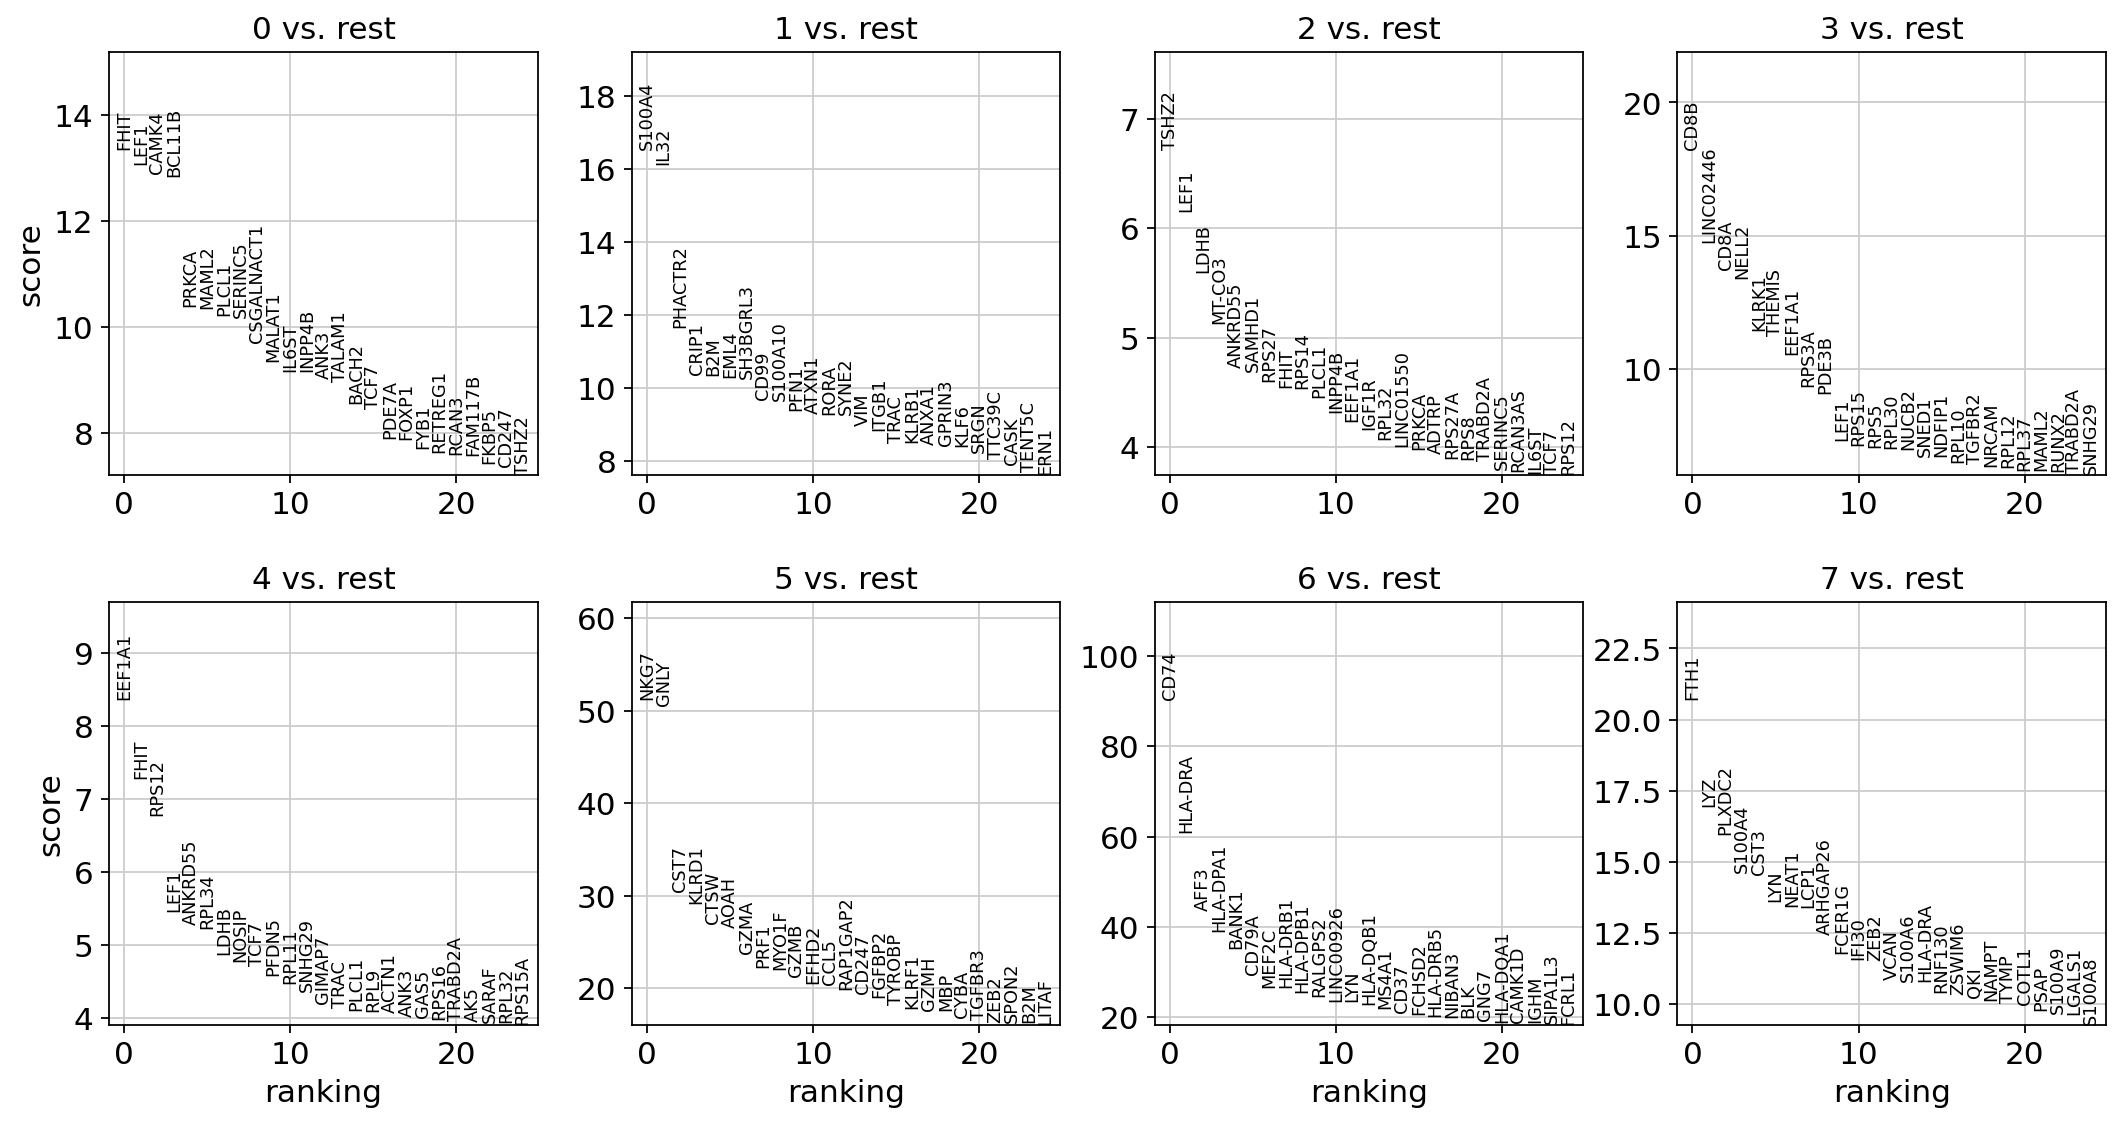

In [32]:
#Finding marker genes: ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before.
#t-test
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [33]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:03)


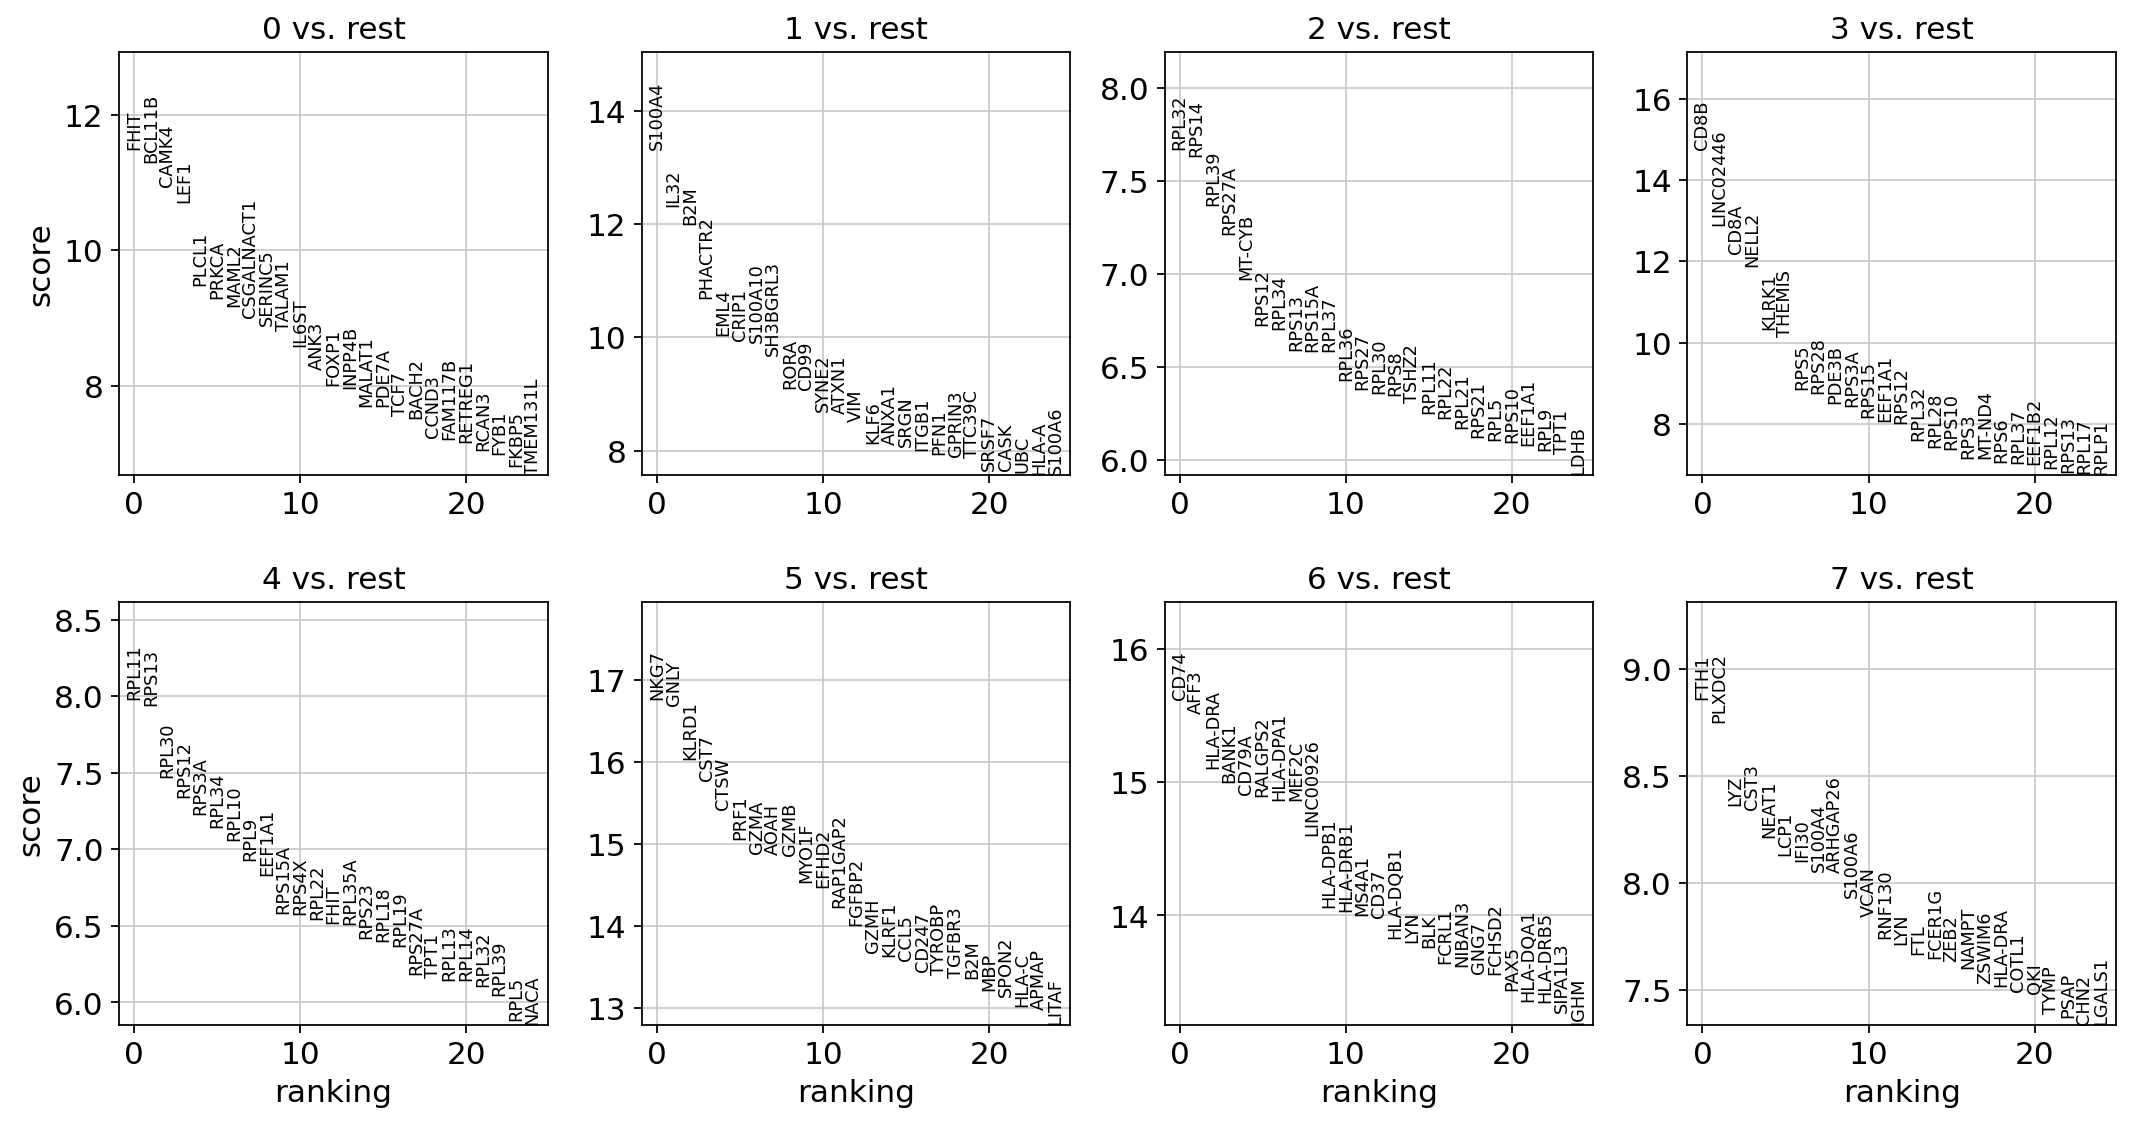

In [34]:
#wilcoxon test
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
adata.write(results_file)

ranking genes
    finished (0:00:50)


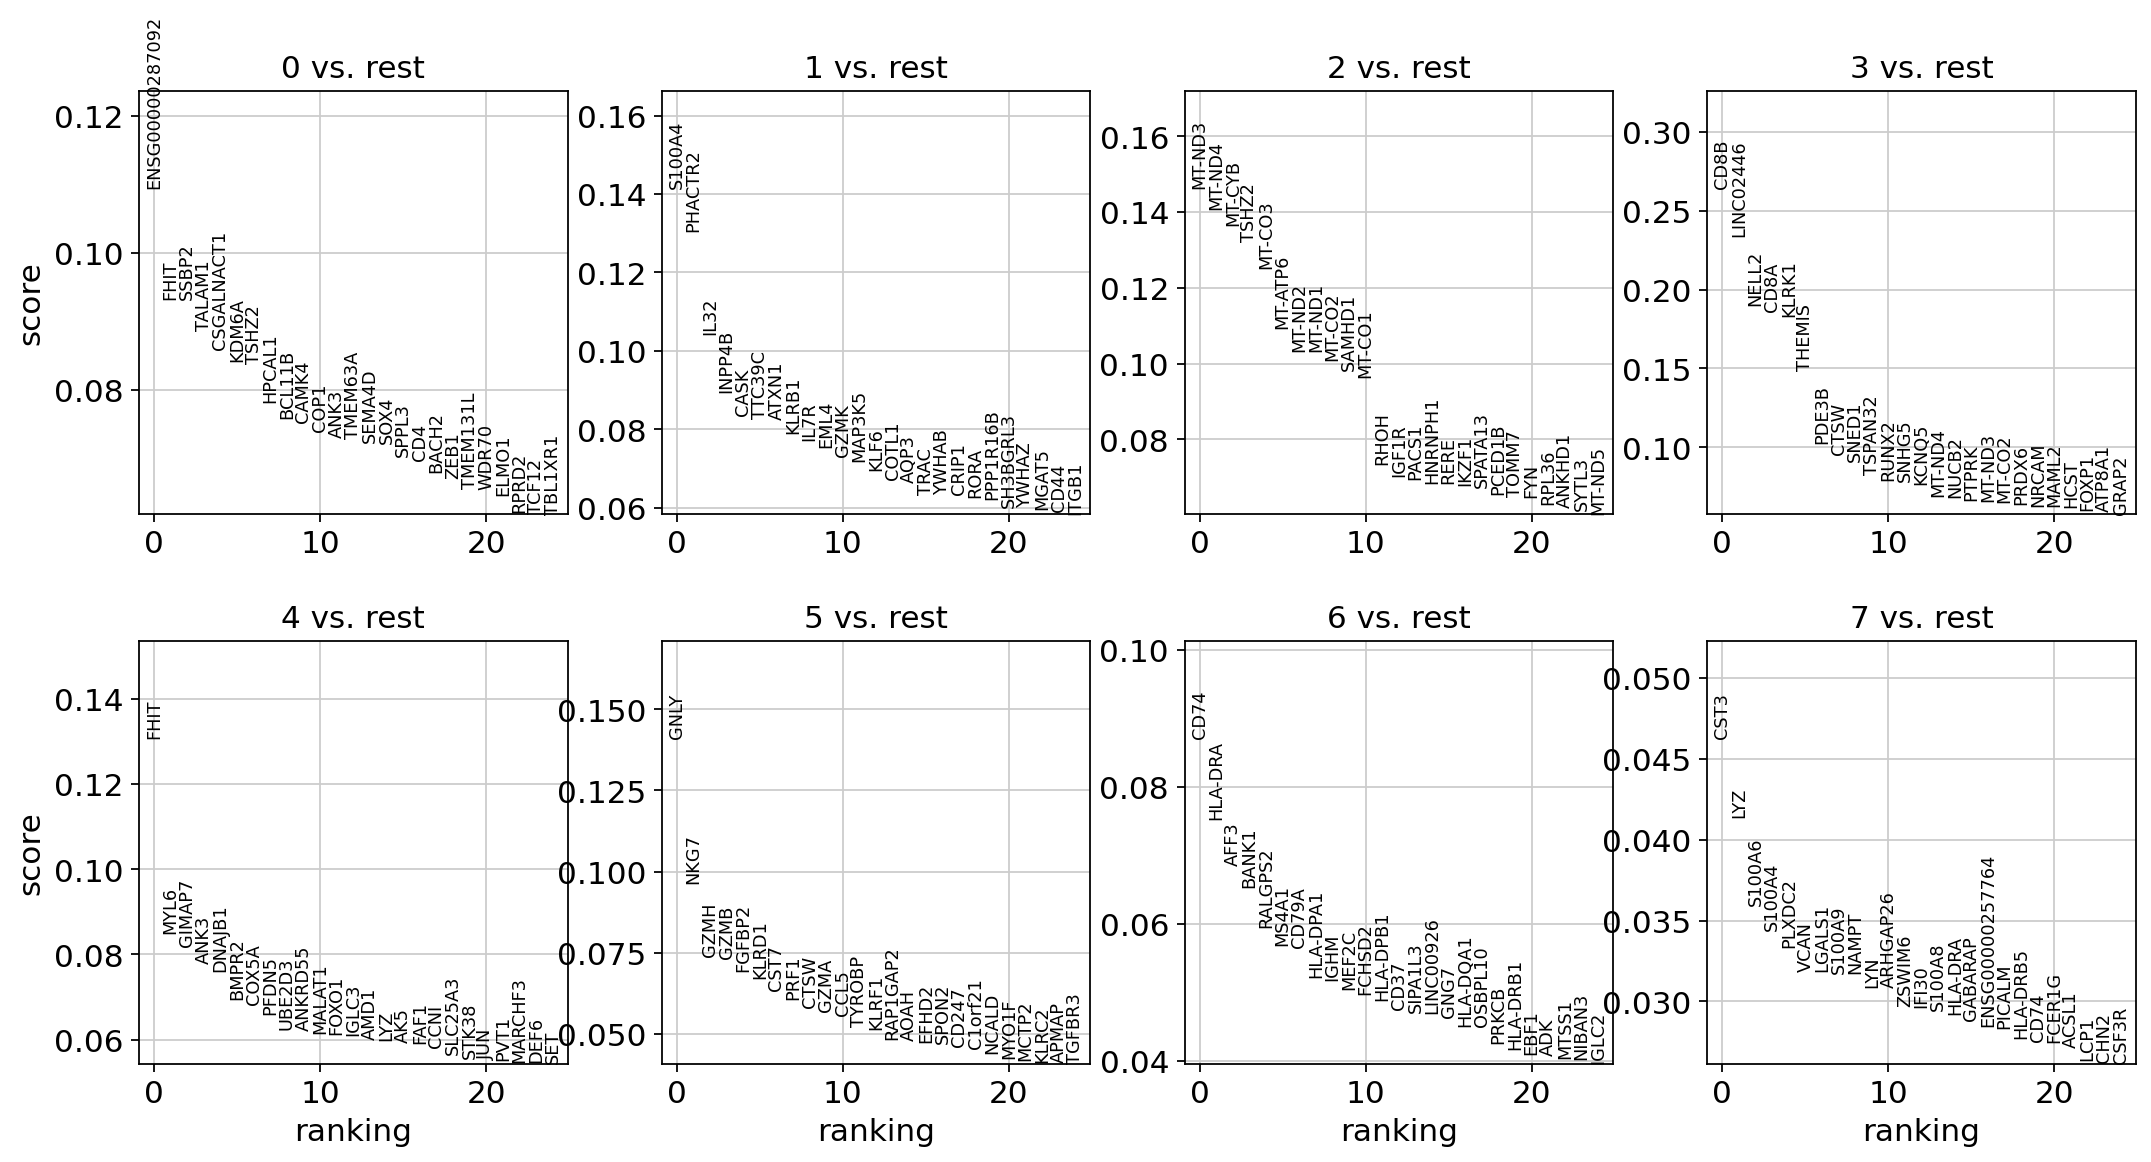

In [36]:
#logistic regression
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [38]:
adata = sc.read(results_file)

/home/tamalika/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [39]:
#the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,FHIT,S100A4,RPL32,CD8B,RPL11,NKG7,CD74,FTH1
1,BCL11B,IL32,RPS14,LINC02446,RPS13,GNLY,AFF3,PLXDC2
2,CAMK4,B2M,RPL39,CD8A,RPL30,KLRD1,HLA-DRA,LYZ
3,LEF1,PHACTR2,RPS27A,NELL2,RPS12,CST7,BANK1,CST3
4,PLCL1,EML4,MT-CYB,KLRK1,RPS3A,CTSW,CD79A,NEAT1


In [40]:
#table with the scores and groups
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)


,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,FHIT,1.555971e-30,S100A4,1.858011e-40,RPL32,1.739057e-14,CD8B,2.771265e-49,RPL11,1.453566e-15,NKG7,4.083977e-63,CD74,4.955791e-55,FTH1,8.181344e-19
1,BCL11B,1.428120e-29,IL32,8.749298e-35,RPS14,2.301453e-14,LINC02446,6.294719e-38,RPS13,2.065564e-15,GNLY,1.398611e-62,AFF3,2.706798e-54,PLXDC2,2.157644e-18
2,CAMK4,7.950781e-28,B2M,4.093305e-33,RPL39,1.712871e-13,CD8A,2.901918e-34,RPL30,8.164128e-14,KLRD1,7.585850e-58,HLA-DRA,1.542739e-51,LYZ,6.270249e-17
3,LEF1,1.015967e-26,PHACTR2,1.241299e-26,RPS27A,5.418230e-13,NELL2,1.583922e-32,RPS12,2.174084e-13,CST7,4.613337e-56,BANK1,7.641277e-51,CST3,7.316809e-17
4,PLCL1,2.455725e-21,EML4,1.132487e-23,MT-CYB,3.212075e-12,KLRK1,5.170901e-25,RPS3A,4.865776e-13,CTSW,1.148453e-53,CD79A,2.763051e-50,NEAT1,2.188926e-16


ranking genes
    finished (0:00:00)


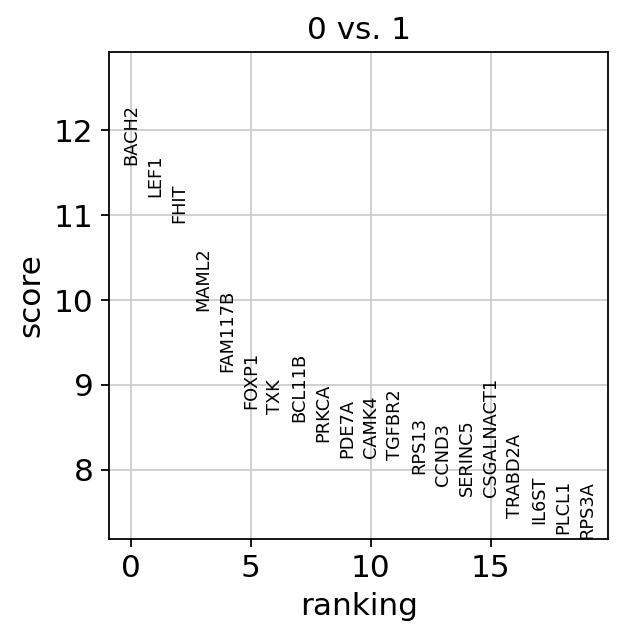

In [41]:
#compare to a single cluster
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/home/tamalika/.local/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


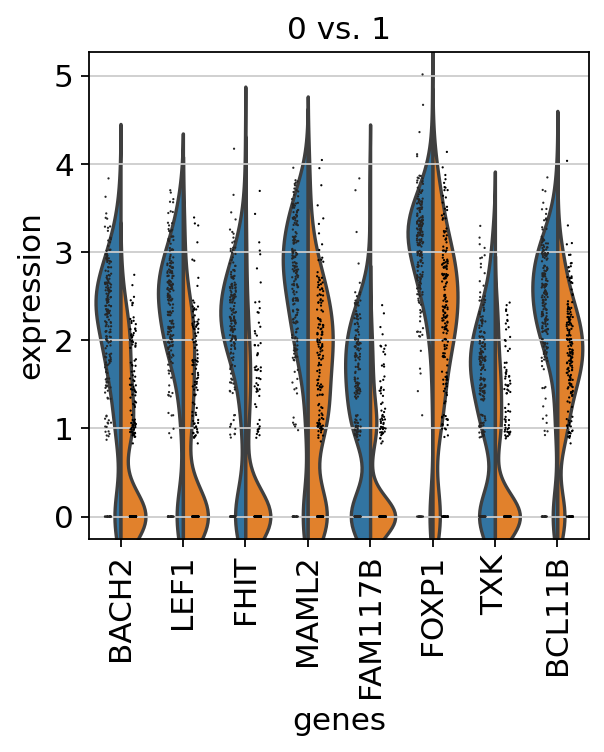

In [42]:
#more detailed view of one group
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [43]:
adata = sc.read(results_file)

/home/tamalika/.local/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/tamalika/.local/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


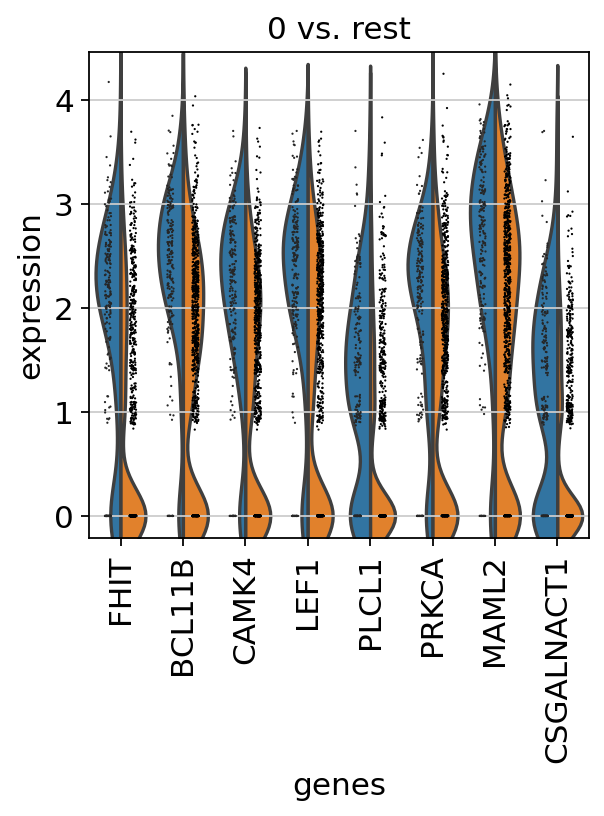

In [44]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

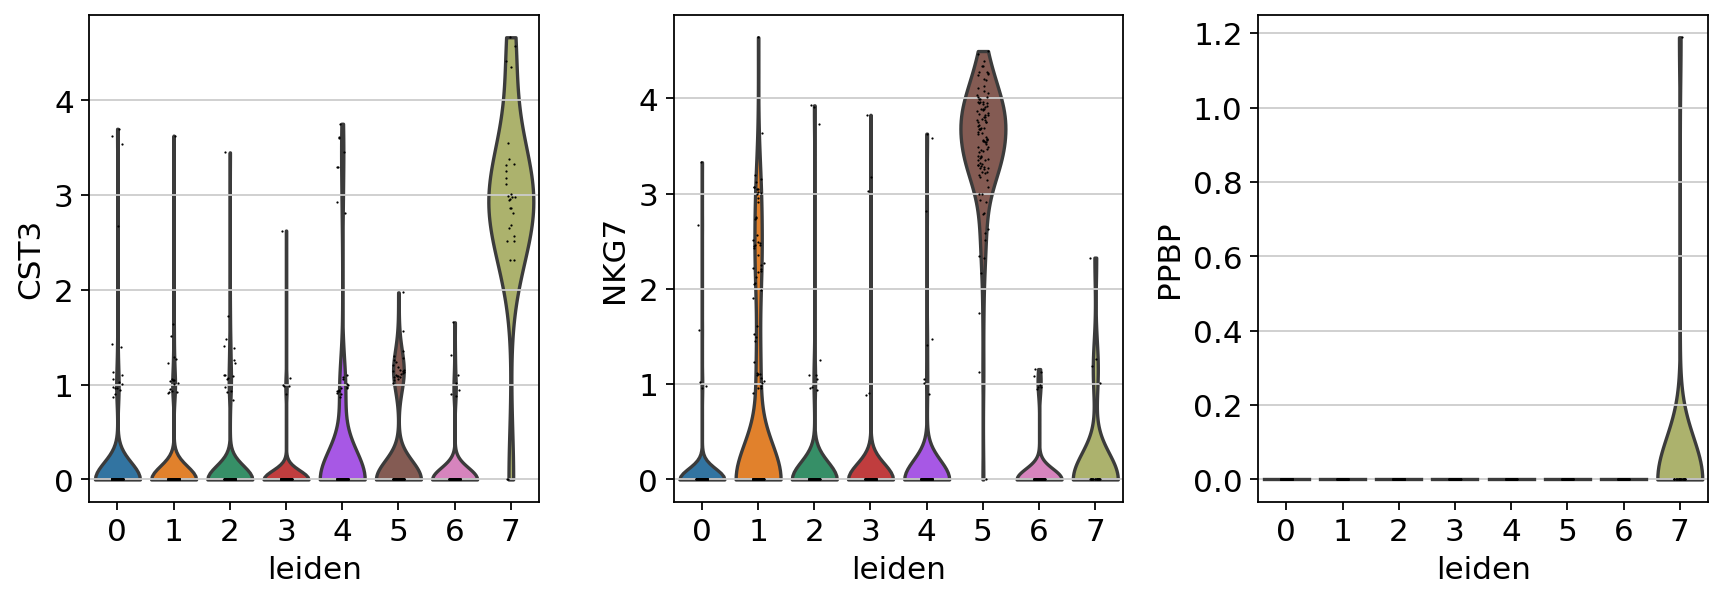

In [45]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")


In [46]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

/home/tamalika/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


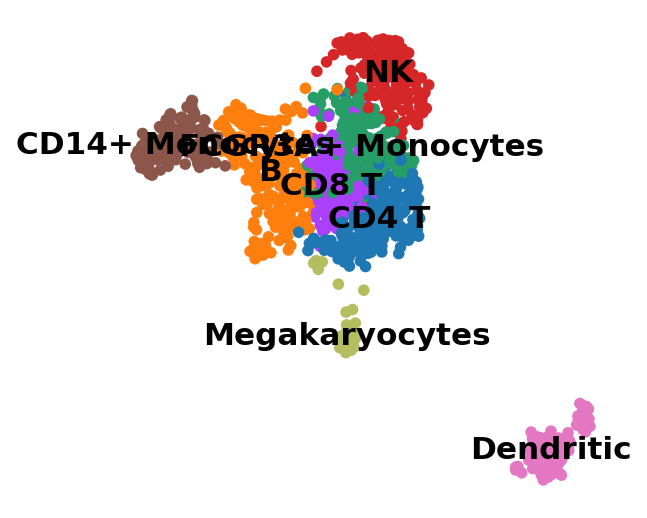

In [47]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)